# 01. Load packages

In [1]:
import math
import os

import numpy as np
import pandas as pds
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0],
    True
)

# 02. View info. of data

In [2]:
df=pds.read_csv('./data/rnn_exam_dataset.csv')
df.shape, df.columns[-1]

((8760, 18), 'Rented Bike Count')

In [3]:
label = 'Rented Bike Count'

In [4]:
cat_columns = ['Seasons','Holiday','Functioning Day','day']
num_columns = list(set(df.columns) - set(cat_columns) -set([label]))

In [5]:
df[cat_columns]

,Seasons,Holiday,Functioning Day,day
0,Winter,No Holiday,Yes,Fri
1,Winter,No Holiday,Yes,Fri
2,Winter,No Holiday,Yes,Fri
3,Winter,No Holiday,Yes,Fri
4,Winter,No Holiday,Yes,Fri
...,...,...,...,...
8755,Autumn,No Holiday,Yes,Fri
8756,Autumn,No Holiday,Yes,Fri
8757,Autumn,No Holiday,Yes,Fri
8758,Autumn,No Holiday,Yes,Fri


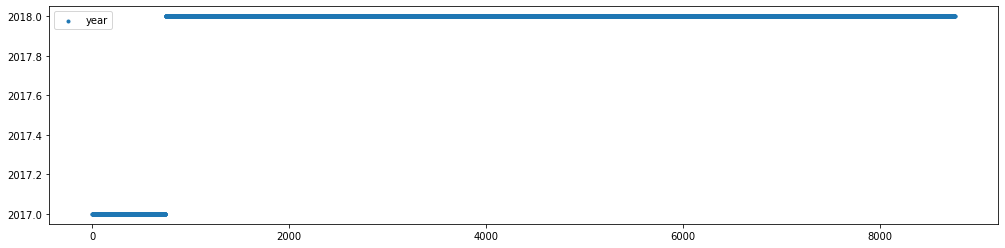

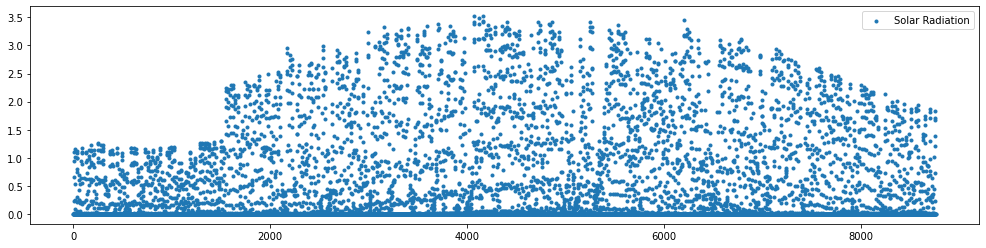

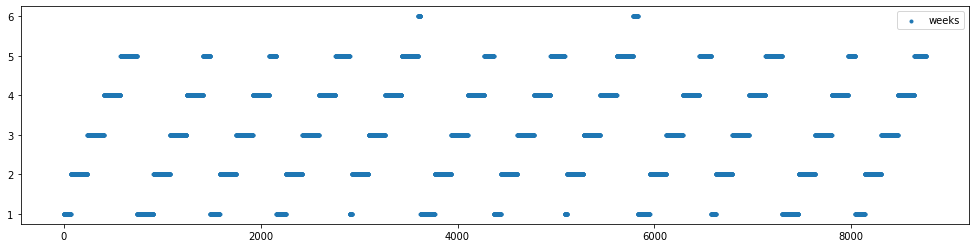

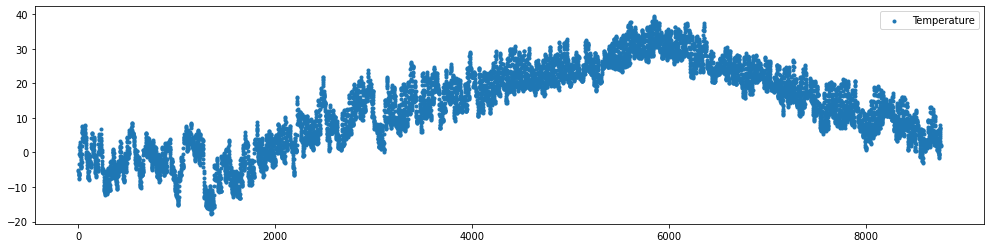

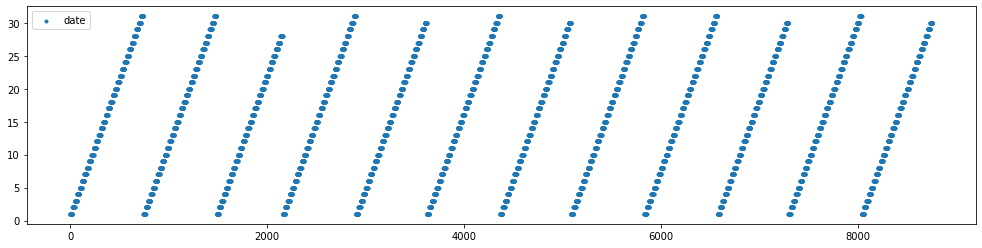

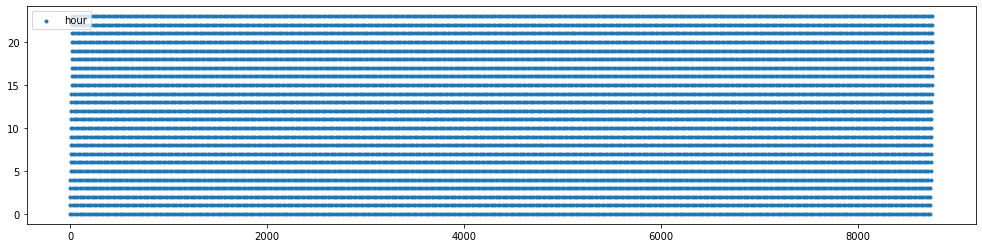

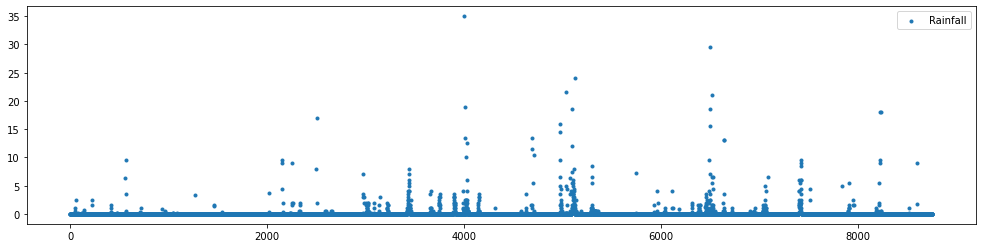

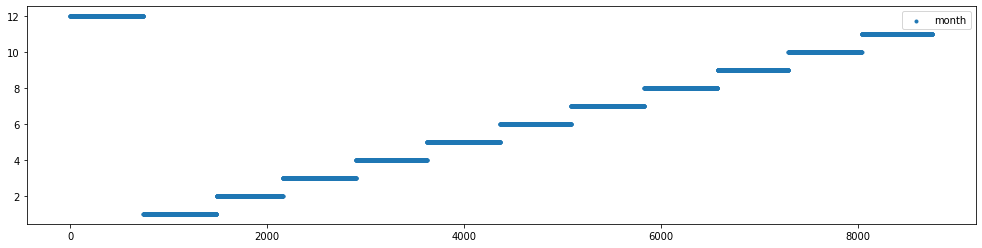

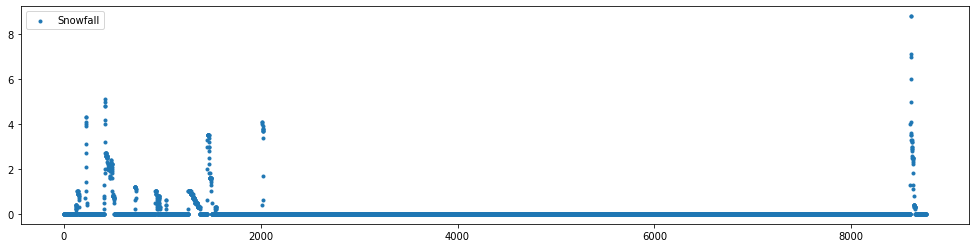

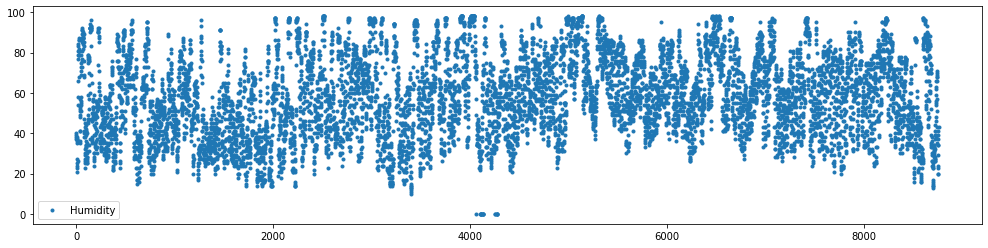

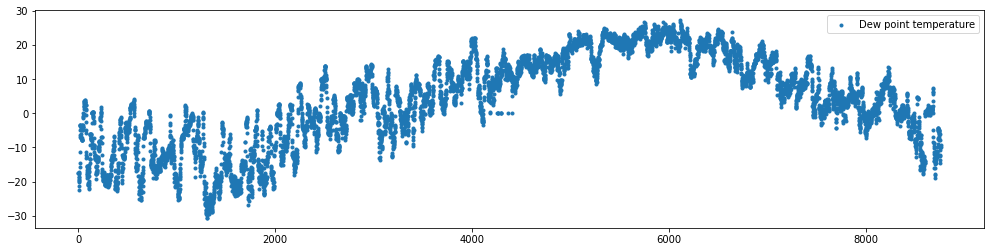

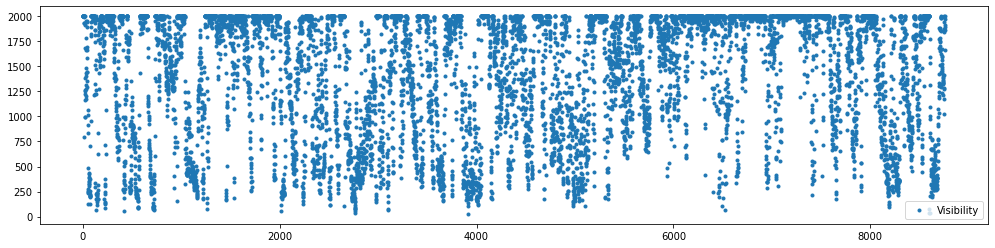

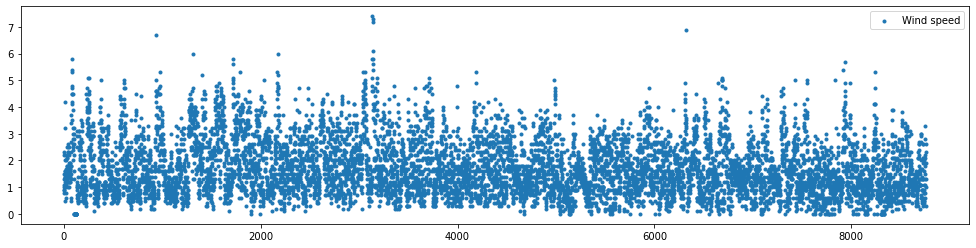

In [6]:
for col in num_columns:
    fig, ax = plt.subplots(1, 1, figsize=(17, 4))
    ax.scatter(range(df.shape[0]), df[col], marker='.', label=col)
    ax.legend()

# 03. Preprocess time-series 

- If the order is based on unit(time), the sequence is gennerally referred to as a __'time-series'__. 
(usually follows discrete, eually-spaced intervals.)


- For allocation of time-series(input data), should employ optimal __window size__ depends on the period size or dominant frequency of the processed dataset. Next, decide whether or not to apply __scaling__ for X (or y), __encoding__ for categorical variables, __hop__, and so on.


- In this project, We are able to predict __'Rented Bike Count' (target)__ corresponding to iuput series.

In [7]:
class Preprocessor():
    
    def __init__(
        self,
        df, # must be label set in last column 
        cat_columns, # list
        scaler, # must be dictionary for X, y
        seq_length, # integer
    ):
        self.df=df 
        self.X, self.y = df.iloc[:,:-1], df.iloc[:,-1]
        self.cat_columns = cat_columns
        self.scaler = scaler
        self.seq_length = seq_length
    
        
    def encoding(self, X, cat_columns):
        
        for column in cat_columns:
            str2num={s:n for n,s in enumerate(X[column].unique())}
            X[column]=X[column].apply(lambda x: str2num[x])
        
        self.X = X
        
        
    def scaling(self, X, y, scaler):
        
        self.X = scaler['X'].fit_transform(X)
        self.y = scaler['y'].fit_transform(np.log(100+np.array(y).reshape(-1, 1)))
        
        self.inv_scaler_y = lambda x: scaler['y'].inverse_transform(x)
        
    # if using tf-version 2.10, can try to use func. called <tf.keras.utils.timeseries_dataset_from_array>
    def sequencing(self, X, y, seq_length):
        
        Xs=[]
        for sig in np.transpose(X):
            Xs.append(
                np.lib.stride_tricks.as_strided( 
                    x=sig,
                    shape=(sig.shape[0]-seq_length+1,seq_length),
                    strides=(sig.strides[0], sig.strides[0])
                )
            )

        ys=np.lib.stride_tricks.as_strided(
            x=y,
            shape=(sig.shape[0]-seq_length+1,seq_length),
            strides=(sig.strides[0], sig.strides[0])
        )

        return np.transpose(np.array(Xs), (1,2,0)), np.reshape(ys, (-1, seq_length, 1))
    
    def __call__(self):
        
        self.encoding(self.X, self.cat_columns)
        self.scaling(self.X, self.y, self.scaler)
        
        return self.sequencing(self.X, self.y, self.seq_length)


In [8]:
seq_length=50

preprocessor=Preprocessor(
        df=pds.read_csv('./data/rnn_exam_dataset.csv'), 
        cat_columns=['Seasons','Holiday','Functioning Day','day'],
        scaler = {
            'X': StandardScaler(),
            'y': MinMaxScaler()
        },
        seq_length=seq_length                   
    )

# 04. Create dataloader

In [9]:
class Dataloader(Sequence):
    def __init__(self, x_set, y_set, batch_size=100, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

        
    def __len__(self):
        return math.floor(len(self.x) / self.batch_size)

    
    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x, dtype=np.float32), np.array(batch_y, dtype=np.float32)

    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [10]:
batch_size=200

loader=Dataloader(
    *preprocessor(),
    batch_size=batch_size
)

In [11]:
for x, y in loader:
    break
x.shape, y.shape

((200, 50, 17), (200, 50, 1))

# 05. RNN module

![rnn_example](https://miro.medium.com/max/724/1*XGIC8IffUKNe1j81AtEcqw.png)  


### 1. Eq. for rnn_unit at a time(t)




$$ h_{t} = tanh(W_{x} x_{t} + W_{h}h_{t−1} + b) $$  


$$ x_t^{B \times d \times 1} \quad W_x^{B \times D_h \times d} \quad W_h^{B \times D_h \times D_h} \quad  h_{t-1}^{B \times D_h \times 1} \quad b^{B \times D_h \times 1} \quad $$


![view_matrix](https://wikidocs.net/images/page/22886/rnn_images4-5.PNG)





$$ y_{t} = f(W_{y}h_{t} + b)\quad (f\, is\, activation\, for\, your\, task) $$



In [21]:
class gru_module(tf.keras.layers.Layer):
    
    def __init__(
        self,
        input_dim,
        output_dim,
        seq,
    ):
        super().__init__()
        
        self.tf_initializer = tf.random_normal_initializer()
        self.input_dim = input_dim
        self.hidden_dim = output_dim
        self.tanh = tf.nn.tanh
        self.sigmoid = tf.nn.sigmoid
        
        self.n_samples, self.seq_len, self.n_features = seq.shape
        
        self.W_xz = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, self.input_dim)), trainable=True)
        self.W_hz = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, self.hidden_dim)), trainable=True)
        self.b_z = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, 1)), trainable=True)
        
        self.W_xr = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, self.input_dim)), trainable=True)
        self.W_hr = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, self.hidden_dim)), trainable=True)
        self.b_r = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, 1)), trainable=True)
        
        self.W_xh_hat = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, self.input_dim)), trainable=True)
        self.W_hh_hat = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, self.hidden_dim)), trainable=True)
        self.b_h_hat = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, 1)), trainable=True)
        
        self.W_ho = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, self.hidden_dim)), trainable=True) # shape[2] : output_size
        
        self.b_o = tf.Variable(self.tf_initializer((self.n_samples, self.hidden_dim, 1)), trainable=True)
    
        self._h =tf.zeros([self.n_samples, self.hidden_dim, 1], name='start')
        
        
    def __call__(self, seq):
        x = seq

        ret = list()
        for t, x_t in enumerate(tf.unstack(x, axis=1)):
            x_t = tf.expand_dims(x_t, -1)
            z = self.sigmoid(self.W_xz @ x_t + \
                             self.W_hz @ self._h + \
                             self.b_z
                            )
            r = self.sigmoid(self.W_xr @ x_t + \
                             self.W_hr @ self._h + \
                             self.b_r
                            )
            h_hat = self.tanh(self.W_xh_hat @ x_t + \
                              self.W_hh_hat @ (r * self._h) + \
                              self.b_h_hat)
            h_t = (1 - z) * self._h + z * h_hat
            
            ret.append(self.W_ho @ h_t + self.b_o)
            self._h = h_t
            
        return tf.transpose(tf.concat(ret, axis=-1), perm=(0,2,1))
            
        
        
class RNN(tf.keras.Model):
    
    def __init__(self, hidden_list, seq, seq_len):
        super().__init__()
        
        self.hidden_list = hidden_list
        self.rnn_layers = [
            gru_module(i,o,seq) for i,o in zip(self.hidden_list, self.hidden_list[1:])
        ]
        
        self.output_layer = tf.keras.layers.Dense(1)
        self.dropout = tf.keras.layers.Dropout(.4)
        self.norms = [
            tf.keras.layers.BatchNormalization() for _ in self.hidden_list[1:]
        ]
        
        
    def __call__(self, x, training=True):
        
        for layer, norm_layer in zip(self.rnn_layers, self.norms):
            x = layer(x)
            x = norm_layer(x)
            
            if training:
                x = self.dropout(x)
            
        
        return self.output_layer(x)

In [22]:
rnn_model = RNN(
    hidden_list=[17, 30, 30, 30], seq=x, seq_len=seq_length
)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.mse

In [23]:
from tqdm import tqdm

def training_batch(epoch):
    TQ = tqdm(loader)

    losses = []

    for n,(x,y) in enumerate(TQ, 1):    
        
        with tf.GradientTape() as tape:
            y_hat=rnn_model(x, training=True)
            scaled_y = tf.transpose(tf.concat([preprocessor.inv_scaler_y(i) for i in y], axis=-1), perm=(1,0))
            mse_loss=loss(y_hat, tf.expand_dims(scaled_y, -1))
        
        grads = tape.gradient(mse_loss, rnn_model.trainable_variables) 
        optimizer.apply_gradients(zip(grads, rnn_model.trainable_variables))

        losses.append(mse_loss.numpy().mean())
 
        TQ.set_postfix_str(f'Loss: {sum(losses) / n:.5}')
        TQ.set_description_str(f'Epoch: {epoch}')
    return losses


def training_epochs(max_epochs):
    losses = []
    for e in range(max_epochs):
        l = training_batch(e+1)
        losses.append(l)
        
    return losses


In [24]:
logger = training_epochs(10)

Epoch: 10: 100%|██████████| 43/43 [00:07<00:00,  5.44it/s, Loss: 0.49813]
